# Unprocess

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

In [2]:
gpus = tf.config.list_physical_devices("GPU")
gpus = gpus[0:2]

tf.config.set_visible_devices(gpus, "GPU")

## Read Image

In [3]:
def read_jpg(filename):
    """Reads an 8-bit JPG file from disk and normalizes to [0, 1]."""
    image_file = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_file, channels=3)
    white_level = 255.0
    return tf.cast(image, tf.float32) / white_level

In [4]:
image = read_jpg(
    "/gpfs_projects/seif.younis/NIH Chest X-rays/images_001/images/00000001_000.png"
)

2022-08-08 11:41:16.550604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 11:41:18.096340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 353 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-08-08 11:41:18.098663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14166 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:05:00.0, compute capability: 7.0


## Unprocessing Functions

In [10]:
def random_ccm():
    """Generates random RGB -> Camera color correction matrices."""
    # Takes a random convex combination of XYZ -> Camera CCMs.
    xyz2cams = [
        [
            [1.0234, -0.2969, -0.2266],
            [-0.5625, 1.6328, -0.0469],
            [-0.0703, 0.2188, 0.6406],
        ],
        [
            [0.4913, -0.0541, -0.0202],
            [-0.613, 1.3513, 0.2906],
            [-0.1564, 0.2151, 0.7183],
        ],
        [
            [0.838, -0.263, -0.0639],
            [-0.2887, 1.0725, 0.2496],
            [-0.0627, 0.1427, 0.5438],
        ],
        [
            [0.6596, -0.2079, -0.0562],
            [-0.4782, 1.3016, 0.1933],
            [-0.097, 0.1581, 0.5181],
        ],
    ]
    num_ccms = len(xyz2cams)
    xyz2cams = tf.constant(xyz2cams)
    weights = tf.random.uniform((num_ccms, 1, 1), 1e-8, 1e8)
    weights_sum = tf.reduce_sum(weights, axis=0)
    xyz2cam = tf.reduce_sum(xyz2cams * weights, axis=0) / weights_sum

    # Multiplies with RGB -> XYZ to get RGB -> Camera CCM.
    rgb2xyz = tf.cast(
        [
            [0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041],
        ],
        tf.float32,
    )
    rgb2cam = tf.matmul(xyz2cam, rgb2xyz)

    # Normalizes each row.
    rgb2cam = rgb2cam / tf.reduce_sum(rgb2cam, axis=-1, keepdims=True)
    return rgb2cam


def random_gains():
    """Generates random gains for brightening and white balance."""
    # RGB gain represents brightening.
    rgb_gain = 1.0 / tf.random.normal((), mean=0.8, stddev=0.1)

    # Red and blue gains represent white balance.
    red_gain = tf.random.uniform((), 1.9, 2.4)
    blue_gain = tf.random.uniform((), 1.5, 1.9)
    return rgb_gain, red_gain, blue_gain


def inverse_smoothstep(image):
    """Approximately inverts a global tone mapping curve."""
    image = tf.clip_by_value(image, 0.0, 1.0)
    return 0.5 - tf.sin(tf.asin(1.0 - 2.0 * image) / 3.0)


def gamma_expansion(image):
    """Converts from gamma to linear space."""
    # Clamps to prevent numerical instability of gradients near zero.
    return tf.maximum(image, 1e-8) ** 2.2


def apply_ccm(image, ccm):
    """Applies a color correction matrix."""
    shape = tf.shape(image)
    image = tf.reshape(image, [-1, 3])
    image = tf.tensordot(image, ccm, axes=[[-1], [-1]])
    return tf.reshape(image, shape)


def safe_invert_gains(image, rgb_gain, red_gain, blue_gain):
    """Inverts gains while safely handling saturated pixels."""
    gains = tf.stack([1.0 / red_gain, 1.0, 1.0 / blue_gain]) / rgb_gain
    gains = gains[tf.newaxis, tf.newaxis, :]

    # Prevents dimming of saturated pixels by smoothly masking gains near white.
    gray = tf.reduce_mean(image, axis=-1, keepdims=True)
    inflection = 0.9
    mask = (tf.maximum(gray - inflection, 0.0) / (1.0 - inflection)) ** 2.0
    safe_gains = tf.maximum(mask + (1.0 - mask) * gains, gains)
    return image * safe_gains


def mosaic(image):
    """Extracts RGGB Bayer planes from an RGB image."""
    image.shape.assert_is_compatible_with((None, None, 3))
    shape = tf.shape(image)
    red = image[0::2, 0::2, 0]
    green_red = image[0::2, 1::2, 1]
    green_blue = image[1::2, 0::2, 1]
    blue = image[1::2, 1::2, 2]
    image = tf.stack((red, green_red, green_blue, blue), axis=-1)
    image = tf.reshape(image, (shape[0] // 2, shape[1] // 2, 4))
    return image


def unprocess(image):
    """Unprocesses an image from sRGB to realistic raw data."""
    with tf.name_scope("unprocess"):
        image.shape.assert_is_compatible_with([None, None, 3])

        # Randomly creates image metadata.
        rgb2cam = random_ccm()
        cam2rgb = tf.linalg.inv(rgb2cam)
        rgb_gain, red_gain, blue_gain = random_gains()

        # Approximately inverts global tone mapping.
        image = inverse_smoothstep(image)
        # Inverts gamma compression.
        image = gamma_expansion(image)
        # Inverts color correction.
        image = apply_ccm(image, rgb2cam)
        # Approximately inverts white balance and brightening.
        image = safe_invert_gains(image, rgb_gain, red_gain, blue_gain)
        # Clips saturated pixels.
        image = tf.clip_by_value(image, 0.0, 1.0)
        # Applies a Bayer mosaic.
        image = mosaic(image)

        metadata = {
            "cam2rgb": cam2rgb,
            "rgb_gain": rgb_gain,
            "red_gain": red_gain,
            "blue_gain": blue_gain,
        }
        return image, metadata


def random_noise_levels():
    """Generates random noise levels from a log-log linear distribution."""
    log_min_shot_noise = tf.math.log(0.0001)
    log_max_shot_noise = tf.math.log(0.012)
    log_shot_noise = tf.random.uniform((), log_min_shot_noise, log_max_shot_noise)
    shot_noise = tf.exp(log_shot_noise)

    line = lambda x: 2.18 * x + 1.20
    log_read_noise = line(log_shot_noise) + tf.random.normal((), stddev=0.26)
    read_noise = tf.exp(log_read_noise)
    return shot_noise, read_noise


def add_noise(image, shot_noise=0.01, read_noise=0.0005):
    """Adds random shot (proportional to image) and read (independent) noise."""
    variance = image * shot_noise + read_noise
    noise = tf.random.normal(tf.shape(image), stddev=tf.sqrt(variance))
    return image + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


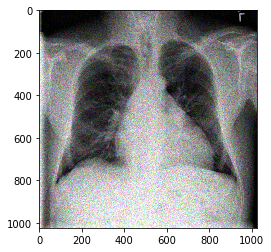

In [13]:
# unprocessed, metadata = unprocess(image)
shot_noise, read_noise = random_noise_levels()
noisy_img = add_noise(image)
plt.imshow(noisy_img.numpy(), interpolation="nearest", cmap="Greys")

## Processing Functions